# Determining the sparsity cutoff that produces the highest number of rejected hypotheses (alternative to DESeq2's independent filtering)

* Based on best cutoff, may needed to re-do the phyloseq dataset partitioning (prior notebook)
* Using multiple 'heavy' BD windows for the DESeq2 analysis
  * 1 DESeq2 run per window
  * combining DESeq2 results
  * global adjustment of P-values

# Setting variables

In [1]:
workDir = '/home/chantal/Chazy/Chazy_SIP/data/Replicates'
figDir = '/home/chantal/Chazy/Chazy_SIP/data/figs/'

physeqDir = '/home/chantal/Chazy/data/phyloseq/'
physeqFile = 'SIP_unk'


# l2fc params
l2fc_threshold = 0.25
BD_windows = ['1.70-1.73', '1.72-1.75', '1.74-1.77']
padj_cutoff = 0.1

# misc
nprocs = 20

# Init

In [2]:
import os
%load_ext rpy2.ipython
#%load_ext pushnote

In [3]:
%%R
library(DESeq2)
library(phyloseq)
library(grid); library(gridExtra)
library(plyr); library(dplyr)
library(tidyr)
library(ggplot2)
library(doParallel)
library(foreach)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: S4Vectors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: stats4

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: BiocGenerics

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: parallel

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘BiocGenerics’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/funct

In [4]:
if not os.path.isdir(workDir):
    os.makedirs(workDir)
    
if not os.path.isdir(figDir):
    os.makedirs(figDir)    

In [5]:
%%R -i l2fc_threshold -i BD_windows -i nprocs -i padj_cutoff

cat('Params loaded in R\n')

Params loaded in R


# Loading phyloseq

In [6]:
%%R -i physeqDir -i physeqFile 

F = file.path(physeqDir, physeqFile)
physeq = readRDS(F)
physeq.m = physeq %>% sample_data
physeq

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 23345 taxa and 994 samples ]
sample_data() Sample Data:       [ 994 samples by 25 sample variables ]
tax_table()   Taxonomy Table:    [ 23345 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 23345 tips and 23344 internal nodes ]


## MW-HR-SIP

In [7]:
%%R
# check on number of gradients

n.gradient = physeq %>% sample_data %>% as.matrix %>% as.data.frame %>%
            distinct(Day, Treatment, Land_Management, Replicate) %>% nrow
cat('Number of gradients:', n.gradient, '\n')

Number of gradients: 42 


In [8]:
%%R
head(physeq %>% sample_data)

Sample Data:        [6 samples by 25 sample variables]:
                                Full.sample Fraction PrimerF PrimerR Barcode
12C.NTH.D3.R4.Frac28   12C.NTH.D3.R4.Frac28       28    515f    806r     174
12C.NTH.D3.R4.Frac22   12C.NTH.D3.R4.Frac22       22    515f    806r     168
13X.NTH.D3.R4.Frac28   13X.NTH.D3.R4.Frac28       28    515f    806r      48
12C.PTH.D3.R4.Frac9     12C.PTH.D3.R4.Frac9        9    515f    806r     180
13X.PTH.D7.R4.Frac10   13X.PTH.D7.R4.Frac10       10    515f    806r      81
13C.PTH.D14.R4.Frac19 13C.PTH.D14.R4.Frac19       19    515f    806r     115
                      Rev.index Fwd.index Treatment Day Replicate Pool
12C.NTH.D3.R4.Frac28   gtctgcta  tcgacgag       12C   3         4    1
12C.NTH.D3.R4.Frac22   actacgac  gtcagata       12C   3         4    1
13X.NTH.D3.R4.Frac28   ctgcgtag  gacaccgt       13X   3         4    1
12C.PTH.D3.R4.Frac9    gtctatga  tacgagac       12C   3         4    1
13X.PTH.D7.R4.Frac10   gtctatga  atcgtacg       13

In [9]:
%%R
     
asNumeric = function(x) { as.numeric(as.character(x)) }

get_Ps = function(physeq.obj, l2fc_threshold, Treatment, Land_Management, Day, Replicate, 
                  sparsity_threshold, density_min, density_max){
        
    # function for calculating log2 fold change p-values
    Treatment = c(Treatment %>% as.character)
    physeq.md = sample_data(physeq.obj)
    
    # filtering
    p.12C = prune_samples((! is.na(physeq.md$Density)) &
                          (physeq.md$Treatment == "12C") &
                          (physeq.md$Day == Day) &
                          (physeq.md$Land_Management == Land_Management),
                           physeq.obj)
    p.13C = prune_samples((! is.na(physeq.md$Density)) & 
                      (physeq.md$Treatment == Treatment) &
                      (physeq.md$Day == Day) &
                      (physeq.md$Replicate == Replicate)&
                      (physeq.md$Land_Management == Land_Management),
                      physeq.obj)
    physeq.m = merge_phyloseq(p.12C, p.13C) 
    physeq.md = sample_data(physeq.m)
    p.12C = p.13C = NULL
    
    # sparcity cutoff applied to all gradient fractions
    physeq.m = filter_taxa(physeq.m, function(x) sum(x > 0) > sparsity_threshold * length(x), TRUE)   
    
    # applying 'heavy' window pruning
    physeq.m = prune_samples((physeq.md$Density >= density_min) &
                             (physeq.md$Density <= density_max),  physeq.m)
    
    # removing 0-abundance taxa
    physeq.m = filter_taxa(physeq.m, function(x) sum(x > 0) > 0 * length(x), TRUE)
        
    # sparsity cutoff applied to just heavy fractions
    #physeq.m = filter_taxa(physeq.m, function(x) sum(x > 0) > sparsity_threshold * length(x), TRUE)
    
    # deseq
    dds = phyloseq_to_deseq2(physeq.m, ~Treatment)
    dds = DESeq(dds, quiet = TRUE, fitType = "local")
    theta = l2fc_threshold
        
    # results
    res = results(dds, independentFiltering=FALSE)
    res$OTU = rownames(res)
        
    # p-value
    beta = res$log2FoldChange
    betaSE = res$lfcSE
    p = pnorm(beta, theta, betaSE, lower.tail=FALSE)
    res$p = p
    d = data.frame(res[, c("OTU","log2FoldChange", "p")])

    # p-value adjust
    d$padj = p.adjust(p, method = "BH")
        
    # taxonomy data
    TT = physeq.m %>% tax_table %>% data.frame
    TT$OTU = rownames(TT)
    d = left_join(d, TT, c('OTU'))
        
    # setting pruning info
    d$density_min = density_min
    d$density_max = density_max
    d$sparsity_threshold = sparsity_threshold
    return(d)
}
                                                         

## Making a table of variable params for the multiple DESeq2 runs

In [10]:
%%R
# list of substrate-day-microcosm rep combinations
## no 12C-con, because it is the comparison 

sdm = physeq %>% sample_data %>% 
    filter(! is.na(Density),
           Treatment != '12C') %>%
    select(Treatment, Day, Replicate, Land_Management) %>%
    distinct() %>%
    arrange(Treatment, Day, Replicate, Land_Management) 

sdm %>% nrow %>% print
sdm %>% head(n=5)

[1] 24
  Treatment Day Replicate Land_Management
1       13C   3         4             NTH
2       13C   3         4             PTH
3       13C   7         4             NTH
4       13C   7         4             PTH
5       13C  14         4             NTH


In [11]:
%%R
# checking that there's only one microcosm replicate per treatment
sdm %>%
    group_by(Treatment, Day, Land_Management) %>%
    summarize(n_reps=n()) #%>%
   # group_by(n_reps) %>%
    #summarize(n_treatments = n())

Source: local data frame [16 x 4]
Groups: Treatment, Day [?]

   Treatment   Day Land_Management n_reps
      (fctr) (int)          (fctr)  (int)
1        13C     3             NTH      1
2        13C     3             PTH      1
3        13C     7             NTH      1
4        13C     7             PTH      1
5        13C    14             NTH      1
6        13C    14             PTH      1
7        13C    30             NTH      3
8        13C    30             PTH      3
9        13X     1             NTH      1
10       13X     1             PTH      1
11       13X     3             NTH      3
12       13X     3             PTH      3
13       13X     7             NTH      1
14       13X     7             PTH      1
15       13X    14             NTH      1
16       13X    14             PTH      1


In [12]:
%%R
# adding range of sparsity thresholds (all pairwise)
sdms = sdm %>%
    unite(sdm, Treatment, Day, Replicate, Land_Management, sep='___')

sdms = expand.grid(sdms$sdm,
                   BD_windows = BD_windows,
                   sparsity_threshold = seq(0.05,0.5,0.05)) %>%
    separate(Var1, c('Treatment', 'Day', 'Replicate', 'Land_Management'), sep='___') %>%
    separate(BD_windows, c('density_min', 'density_max'), sep='-')


cat('Number of pairwise combinations of variables:', sdms %>% nrow, '\n\n')
sdms %>% head(n=3) %>% print
print('-------------------')
sdms %>% tail(n=3) %>% print

Number of pairwise combinations of variables: 720 

  Treatment Day Replicate Land_Management density_min density_max
1       13C   3         4             NTH        1.70        1.73
2       13C   3         4             PTH        1.70        1.73
3       13C   7         4             NTH        1.70        1.73
  sparsity_threshold
1               0.05
2               0.05
3               0.05
[1] "-------------------"
    Treatment Day Replicate Land_Management density_min density_max
718       13X   7         4             PTH        1.74        1.77
719       13X  14         4             NTH        1.74        1.77
720       13X  14         4             PTH        1.74        1.77
    sparsity_threshold
718                0.5
719                0.5
720                0.5


## DESeq2 runs

In [13]:
%%R 
registerDoParallel(nprocs)

df.l2fc = mdply(sdms,
                get_Ps, 
                .parallel = TRUE, 
                physeq.obj = physeq,
                l2fc_threshold = l2fc_threshold) %>% tbl_df

df.l2fc %>% head(n=3) %>% as.data.frame

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:1

  Treatment Day Replicate Land_Management      OTU log2FoldChange         p
1       13C   3         4             NTH OTU.4940     0.04502903 0.5497561
2       13C   3         4             NTH OTU.4163     1.00312420 0.2594451
3       13C   3         4             NTH OTU.5493    -1.78461359 0.8310358
  padj    Rank1           Rank2   Rank3                  Rank4 Rank5 Rank6
1    1 Bacteria __Acidobacteria __32-21 __uncultured_bacterium  <NA>  <NA>
2    1 Bacteria   __Chloroflexi  __S085 __uncultured_bacterium  <NA>  <NA>
3    1 Bacteria   __Chloroflexi  __S085 __uncultured_bacterium  <NA>  <NA>
  Rank7 Rank8 density_min density_max sparsity_threshold
1  <NA>  <NA>        1.70        1.73               0.05
2  <NA>  <NA>        1.70        1.73               0.05
3  <NA>  <NA>        1.70        1.73               0.05


In [14]:
%%R -i workDir
# saving results

outFile = paste(c(workDir, 'MWHRSIP_all-sparsity_df'), collapse='/')
saveRDS(df.l2fc, outFile)

In [15]:
%pushnote 1_sparsity_cutoff DESeq2 complete

ERROR: Line magic function `%pushnote` not found.


## Summing number of rejected hypotheses per DESeq2 run

In [16]:
%%R -i workDir
# reading in results
inFile = paste(c(workDir, 'MWHRSIP_all-sparsity_df'), collapse='/')
df.l2fc = readRDS(inFile)
df.l2fc$Day = reorder(df.l2fc$Day, df.l2fc$Day %>% as.numeric)

# status
df.l2fc %>% head(n=3) %>% as.data.frame

  Treatment Day Replicate Land_Management      OTU log2FoldChange         p
1       13C   3         4             NTH OTU.4940     0.04502903 0.5497561
2       13C   3         4             NTH OTU.4163     1.00312420 0.2594451
3       13C   3         4             NTH OTU.5493    -1.78461359 0.8310358
  padj    Rank1           Rank2   Rank3                  Rank4 Rank5 Rank6
1    1 Bacteria __Acidobacteria __32-21 __uncultured_bacterium  <NA>  <NA>
2    1 Bacteria   __Chloroflexi  __S085 __uncultured_bacterium  <NA>  <NA>
3    1 Bacteria   __Chloroflexi  __S085 __uncultured_bacterium  <NA>  <NA>
  Rank7 Rank8 density_min density_max sparsity_threshold
1  <NA>  <NA>        1.70        1.73               0.05
2  <NA>  <NA>        1.70        1.73               0.05
3  <NA>  <NA>        1.70        1.73               0.05


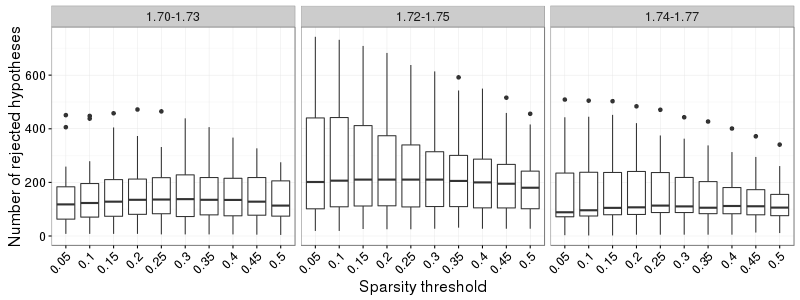

In [17]:
%%R -w 800 -h 300
df.l2fc.s = df.l2fc %>%
    unite(density_window, density_min, density_max, sep='-', remove=FALSE) %>%
    mutate(rej_hypo = padj < padj_cutoff) %>%
    group_by(density_window, sparsity_threshold, Treatment, Day, Replicate, Land_Management) %>%
    summarize(n_rej_hypo = sum(rej_hypo, na.rm=TRUE)) 


ggplot(df.l2fc.s, aes(sparsity_threshold %>% as.character, n_rej_hypo)) +
    geom_boxplot() +
    facet_wrap(~ density_window) +
    labs(x='Sparsity threshold', y='Number of rejected hypotheses') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1)
    )

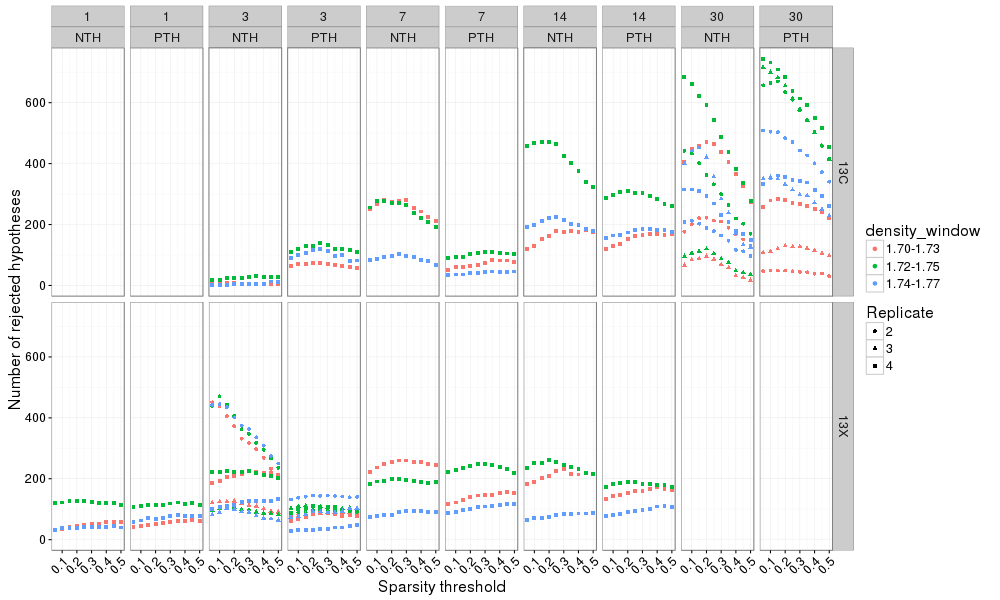

In [18]:
%%R -w 1000 -h 600
ggplot(df.l2fc.s, aes(sparsity_threshold, n_rej_hypo, color=density_window, shape = Replicate)) +
    geom_point() +
    facet_grid(Treatment ~ Day + Land_Management) +
    labs(x='Sparsity threshold', y='Number of rejected hypotheses') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1)
    )

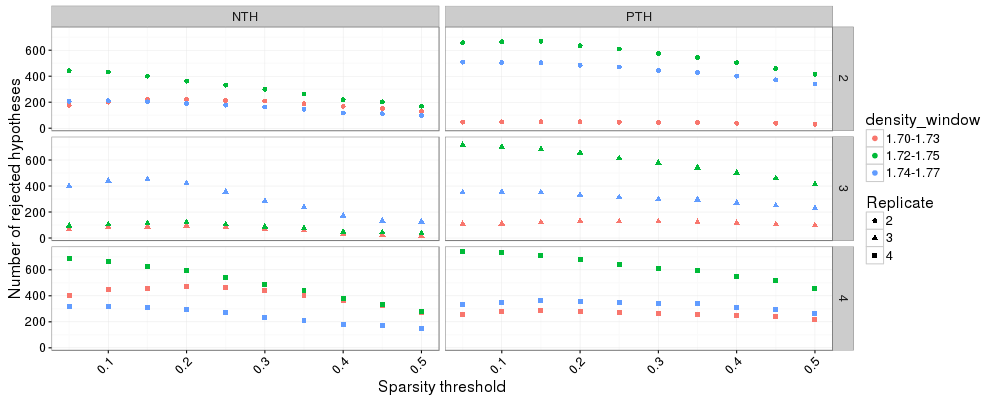

In [19]:
%%R -w 1000 -h 400

df.l2fc.s.test = df.l2fc.s %>% filter(Day == 30, Treatment == '13C')

ggplot(df.l2fc.s.test, aes(sparsity_threshold, n_rej_hypo, color=density_window, shape = Replicate)) +
    geom_point(size = 2) +
    facet_grid(Replicate ~ Land_Management) +
    labs(x='Sparsity threshold', y='Number of rejected hypotheses') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1) 
    )

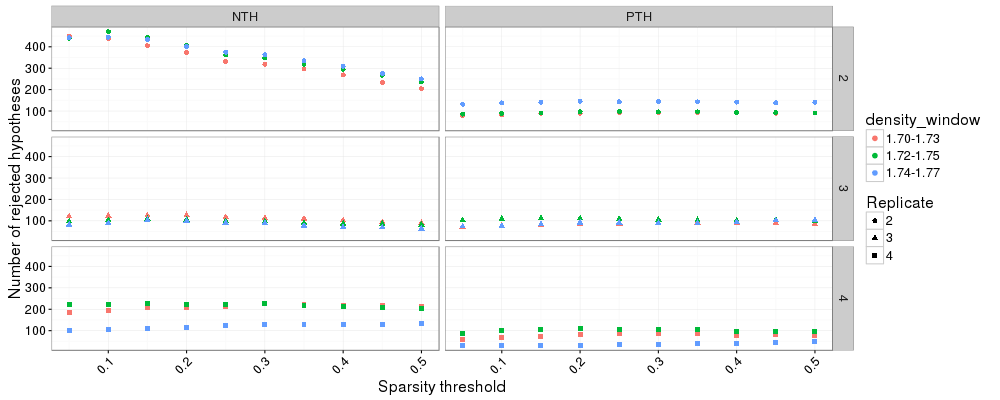

In [20]:
%%R -w 1000 -h 400

df.l2fc.s.test = df.l2fc.s %>% filter(Day == 3, Treatment == '13X')

ggplot(df.l2fc.s.test, aes(sparsity_threshold, n_rej_hypo, color=density_window, shape = Replicate)) +
    geom_point(size = 2) +
    facet_grid(Replicate ~ Land_Management) +
    labs(x='Sparsity threshold', y='Number of rejected hypotheses') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1) 
    )

### Number of taxa for each  sparsity cutoff

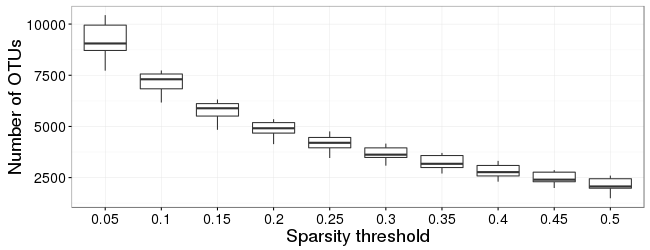

In [21]:
%%R -w 650 -h 250
# plotting number of OTUs after filtering
df.l2fc.s = df.l2fc %>%
    mutate(Day = Day %>% as.character %>% as.numeric) %>%
    group_by(Treatment, Day, Replicate, Land_Management, sparsity_threshold) %>%
    summarize(n_OTUs = OTU %>% unique %>% length) 

ggplot(df.l2fc.s, aes(sparsity_threshold %>% as.character, n_OTUs)) +
    geom_boxplot() +
    labs(x='Sparsity threshold', y='Number of OTUs') +
    theme_bw() +
    theme(
        text = element_text(size=18),
        axis.title.y = element_text(vjust=1)
        ) 

## For each treatment, selecting sparsity cutoff with most rejHypo

In [22]:
%%R
# selecting sparsity cutoffs
cat('Pre-filter:', df.l2fc %>% nrow, '\n')
df.l2fc.f = df.l2fc %>%
    group_by(Treatment, Day, Replicate, Land_Management, sparsity_threshold, density_min, density_max) %>% 
    mutate(n_rej_hypo = sum(padj < padj_cutoff, na.rm=TRUE)) %>%  # nRejHypos for each treat-spar-window combo
    group_by(Treatment, Day, Replicate, Land_Management, density_min, density_max) %>%
    filter(n_rej_hypo == max(n_rej_hypo)) %>%   # just best sparsity for treat-window combo
    ungroup() %>%
    distinct(Treatment, Day, Replicate, Land_Management, density_min, density_max, OTU) 
cat('Post-filter:', df.l2fc.f %>% nrow, '\n')

df.l2fc.f %>% head(n=3) %>% as.data.frame

Pre-filter: 3212206 
Post-filter: 354843 
  Treatment Day Replicate Land_Management      OTU log2FoldChange         p
1       13C   3         4             NTH OTU.4940     0.04502903 0.5497561
2       13C   3         4             NTH OTU.4163     1.00312420 0.2594451
3       13C   3         4             NTH OTU.5493    -1.78461359 0.8310358
  padj    Rank1           Rank2   Rank3                  Rank4 Rank5 Rank6
1    1 Bacteria __Acidobacteria __32-21 __uncultured_bacterium  <NA>  <NA>
2    1 Bacteria   __Chloroflexi  __S085 __uncultured_bacterium  <NA>  <NA>
3    1 Bacteria   __Chloroflexi  __S085 __uncultured_bacterium  <NA>  <NA>
  Rank7 Rank8 density_min density_max sparsity_threshold n_rej_hypo
1  <NA>  <NA>        1.70        1.73               0.05          8
2  <NA>  <NA>        1.70        1.73               0.05          8
3  <NA>  <NA>        1.70        1.73               0.05          8


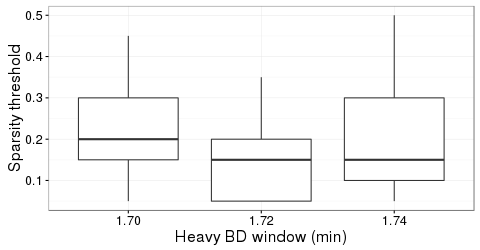

In [23]:
%%R -h 250
ggplot(df.l2fc.f, aes(density_min, sparsity_threshold)) +
    geom_boxplot() +
    labs(x='Heavy BD window (min)', y='Sparsity threshold') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

## Global correction of p-values

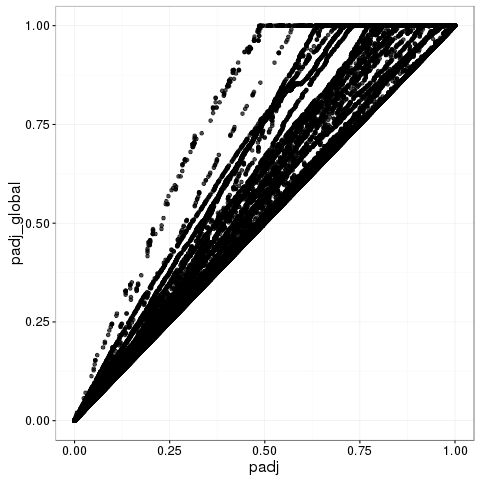

In [24]:
%%R
df.l2fc.f = df.l2fc.f %>%
    group_by(Treatment, Day, Replicate, Land_Management) %>%
    mutate(padj_global = p.adjust(p, method='BH'),
           padj_global = ifelse(padj_global < padj, padj, padj_global)) %>%
    ungroup() 

p1 = ggplot(df.l2fc.f, aes(padj, padj_global)) +
    geom_point(alpha=0.7) +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

df.l2fc.f = df.l2fc.f %>%
    mutate(padj = padj_global) %>%
    select(-padj_global)

p1

## Selecting max l2fc for each treatment-OTU

In [25]:
%%R
cat('Pre-filter:', df.l2fc.f %>% nrow, '\n')
df.l2fc.f = df.l2fc.f %>%
    group_by(Treatment, Day, Replicate, Land_Management, OTU) %>%
    filter(log2FoldChange == max(log2FoldChange, na.rm=TRUE)) %>%
    ungroup() %>%
    distinct(Treatment, Day, Replicate, Land_Management, OTU) %>%
    select(-n_rej_hypo)
cat('Post-filter:', df.l2fc.f %>% nrow, '\n')

Pre-filter: 354843 
Post-filter: 149738 


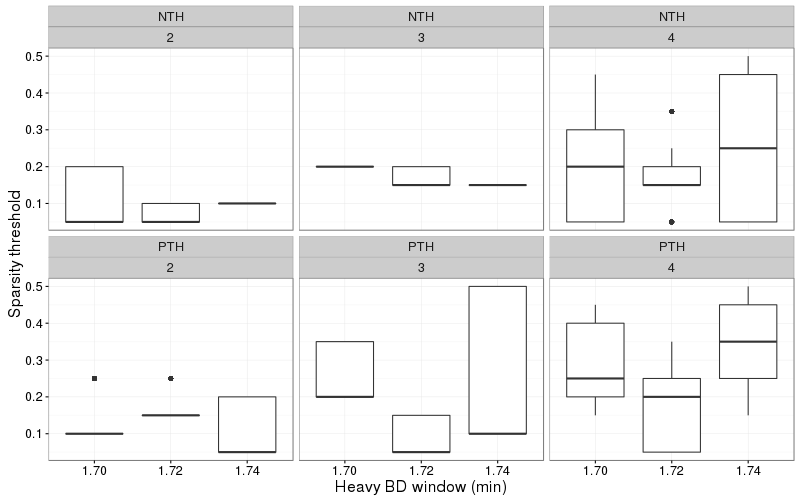

In [26]:
%%R -h 500 -w 800
ggplot(df.l2fc.f, aes(density_min, sparsity_threshold)) +
    geom_boxplot() +
    labs(x='Heavy BD window (min)', y='Sparsity threshold') +
    theme_bw() +
    theme(
        text = element_text(size=16) 
    ) + facet_wrap(Land_Management ~ Replicate)

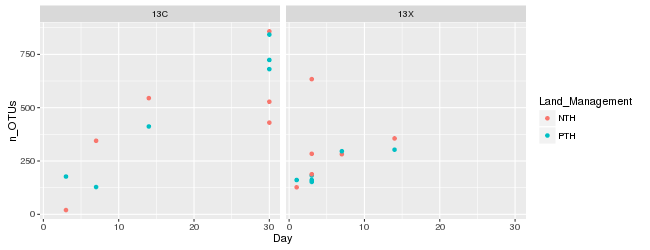

In [27]:
%%R -w 650 -h 250
# plotting number of OTUs after filtering
df.l2fc.f.s = df.l2fc.f %>%
    mutate(Day = Day %>% as.character %>% as.numeric) %>% filter(padj <=0.10) %>%
    group_by(Treatment, Day, Replicate, Land_Management) %>%
    summarize(n_OTUs = n()) 

ggplot(df.l2fc.f.s, aes(Day, n_OTUs, color=Land_Management, group=Replicate)) +
    geom_point()  + facet_wrap(~Treatment)
    #geom_line()

In [28]:
%%R
# checking that there's only 1 OTU value per treatment
df.l2fc.f %>%
    group_by(Treatment, Day, Replicate, Land_Management, sparsity_threshold, OTU) %>%
    summarize(n = n()) %>%
    ungroup %>%
    filter(n > 1) %>% as.data.frame

[1] Treatment          Day                Replicate          Land_Management   
[5] sparsity_threshold OTU                n                 
<0 rows> (or 0-length row.names)


In [29]:
%%R -i workDir
# Writing out l2fc table

outFile = file.path(workDir, 'l2fc_sparse-maxRejH.txt')
write.table(df.l2fc.f, outFile, sep='\t', quote=FALSE, row.names=FALSE)

# Plotting the results

## l2fc plot

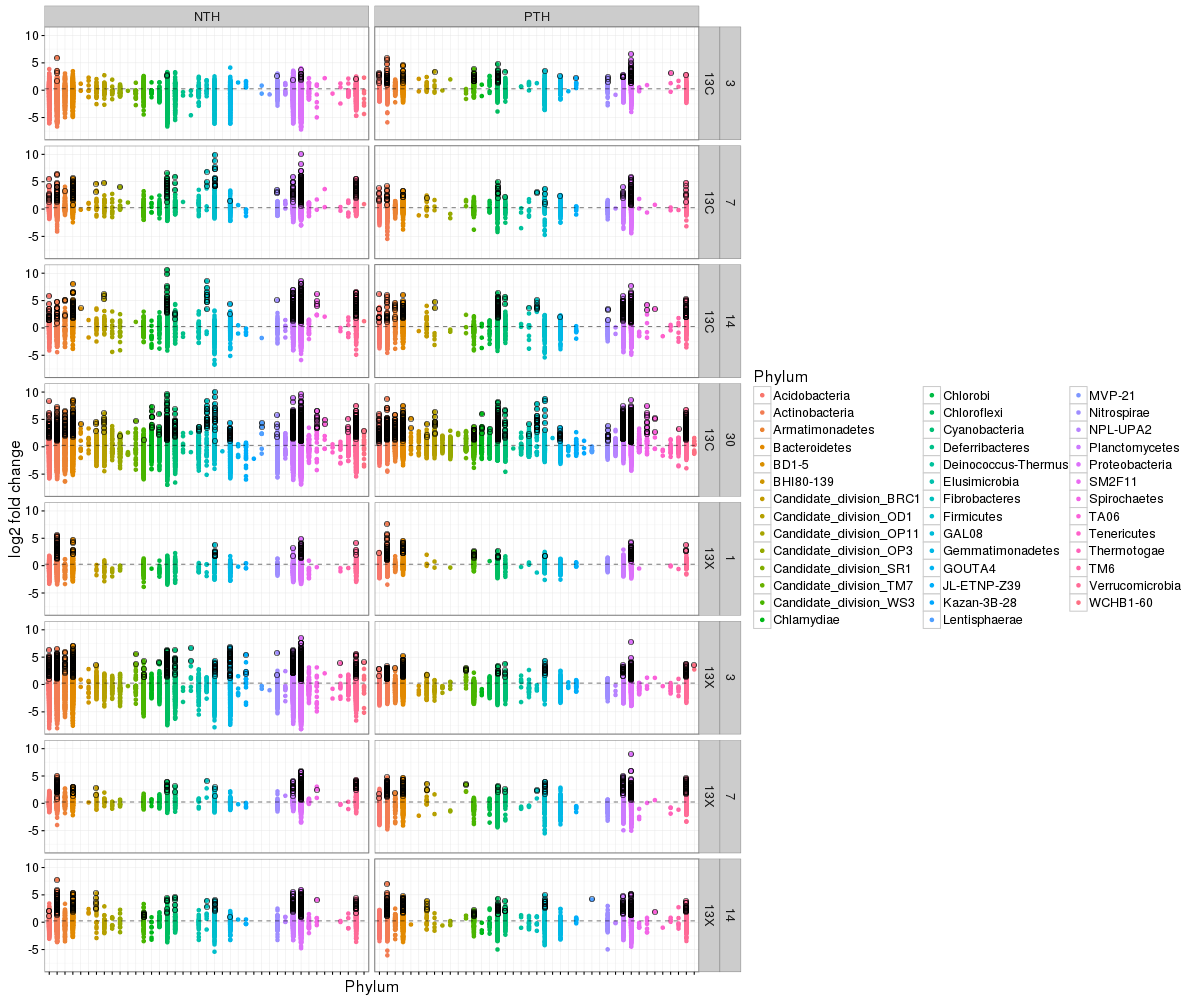

In [30]:
%%R -w 1200 -h 1000

df.l2fc.f = df.l2fc.f %>%
    mutate(Rank2 = gsub('^__', '', Rank2))

df.l2fc.f.sig = df.l2fc.f %>%
    filter(padj < padj_cutoff) %>%
    mutate(Rank2 = gsub('^__', '', Rank2))

p.l2fc = ggplot(df.l2fc.f, aes(Rank2, color=Rank2)) +
    geom_point(aes(y=log2FoldChange)) +
    geom_point(data=df.l2fc.f.sig, aes(y=log2FoldChange), shape='O', color='black', alpha=0.8, size=2.5) +
    geom_hline(yintercept=l2fc_threshold, alpha=0.5, linetype='dashed') +
    facet_grid(Treatment ~ Day ~ Land_Management) +
    scale_color_discrete('Phylum') +
    labs(x = 'Phylum', y='log2 fold change') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_blank()
        )
p.l2fc

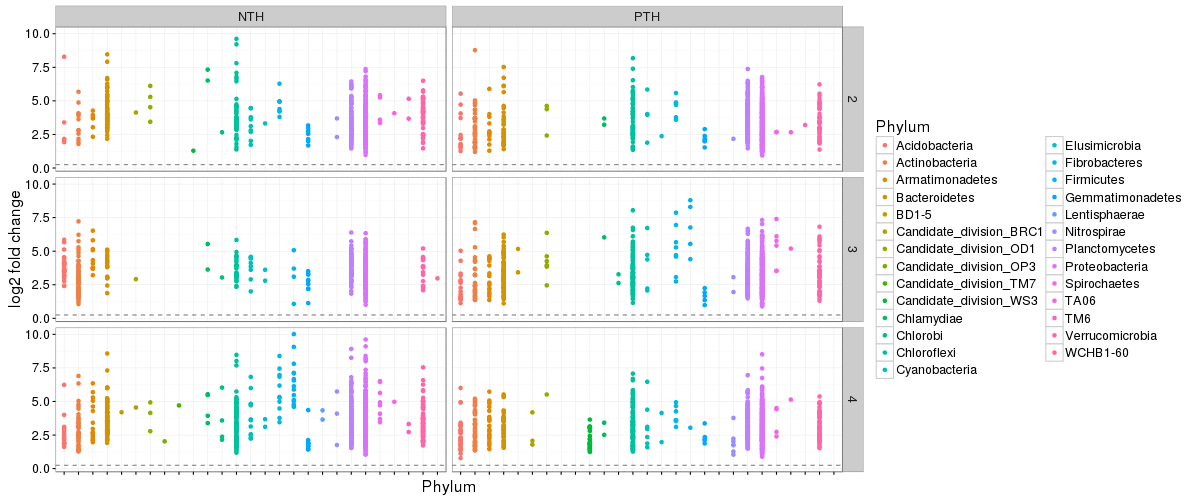

In [31]:
%%R -w 1200 -h 500
#Just significant OTUs...

df.l2fc.f = df.l2fc.f %>%
    mutate(Rank2 = gsub('^__', '', Rank2))

df.l2fc.f.sig = df.l2fc.f %>%
    filter(padj < padj_cutoff, Treatment == '13C', Day == 30) %>%
    mutate(Rank2 = gsub('^__', '', Rank2))

p.l2fc = ggplot(df.l2fc.f.sig, aes(Rank2, color=Rank2)) +
    geom_point(aes(y=log2FoldChange)) +
    #geom_point(data=df.l2fc.f.sig, aes(y=log2FoldChange), shape='O', color='black', alpha=0.8, size=2.5) +
    geom_hline(yintercept=l2fc_threshold, alpha=0.5, linetype='dashed') +
    facet_grid(Replicate ~ Land_Management) +
    scale_color_discrete('Phylum') +
    labs(x = 'Phylum', y='log2 fold change') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_blank()
        )
p.l2fc

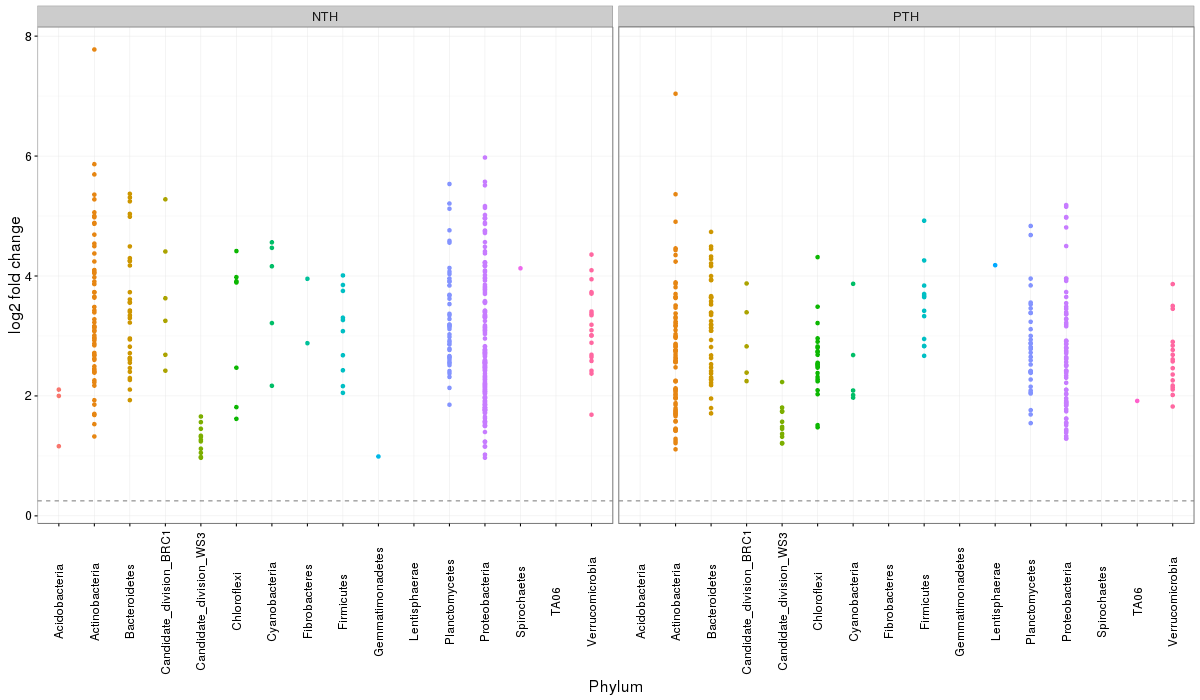

In [32]:
%%R -w 1200 -h 700
#Just significant OTUs...

df.l2fc.f = df.l2fc.f %>%
    mutate(Rank2 = gsub('^__', '', Rank2))

df.l2fc.f.sig = df.l2fc.f %>%
    filter(padj < padj_cutoff, Treatment == '13X', Day == 14) %>%
    mutate(Rank2 = gsub('^__', '', Rank2))

p.l2fc = ggplot(df.l2fc.f.sig, aes(Rank2, color=Rank2)) +
    geom_point(aes(y=log2FoldChange)) +
    #geom_point(data=df.l2fc.f.sig, aes(y=log2FoldChange), shape='O', color='black', alpha=0.8, size=2.5) +
    geom_hline(yintercept=l2fc_threshold, alpha=0.5, linetype='dashed') +
    facet_grid( .~ Land_Management) +
    scale_color_discrete('Phylum') +
    labs(x = 'Phylum', y='log2 fold change') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x  = element_text(angle=90, vjust=0.5, size=12)
        )  + guides(color = FALSE)
p.l2fc

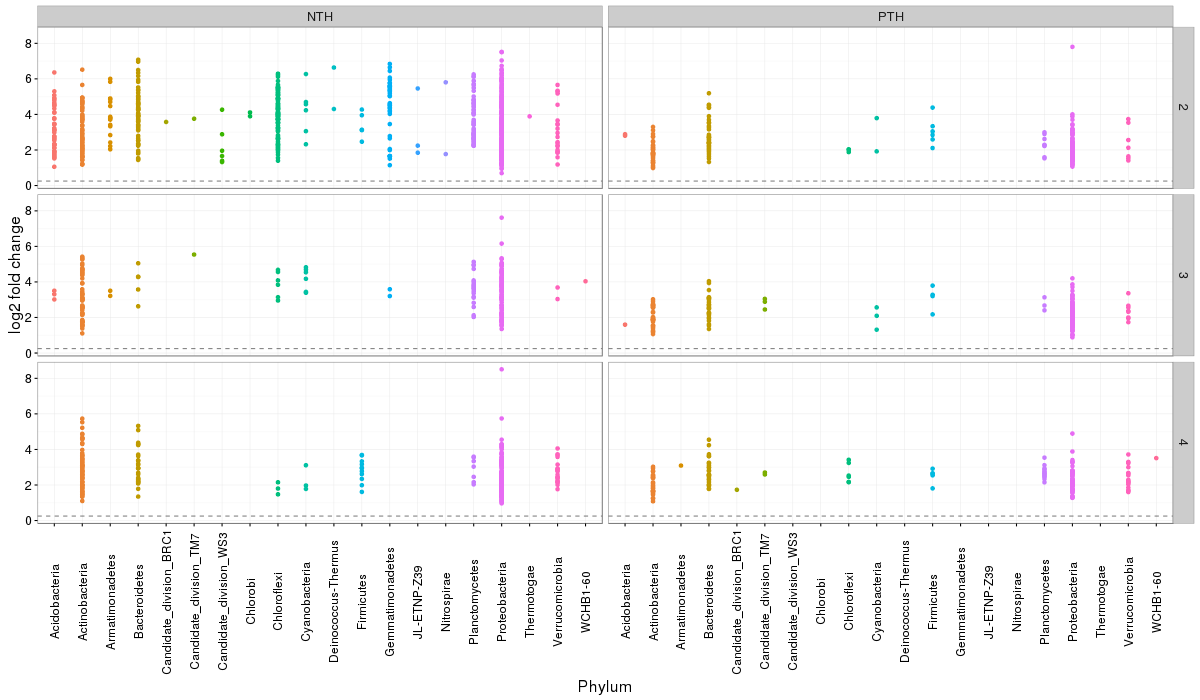

In [33]:
%%R -w 1200 -h 700
#Just significant OTUs...

df.l2fc.f = df.l2fc.f %>%
    mutate(Rank2 = gsub('^__', '', Rank2))

df.l2fc.f.sig = df.l2fc.f %>%
    filter(padj < padj_cutoff, Treatment == '13X', Day == 3) %>%
    mutate(Rank2 = gsub('^__', '', Rank2))

p.l2fc = ggplot(df.l2fc.f.sig, aes(Rank2, color=Rank2)) +
    geom_point(aes(y=log2FoldChange)) +
    #geom_point(data=df.l2fc.f.sig, aes(y=log2FoldChange), shape='O', color='black', alpha=0.8, size=2.5) +
    geom_hline(yintercept=l2fc_threshold, alpha=0.5, linetype='dashed') +
    facet_grid(Replicate ~ Land_Management) +
    scale_color_discrete('Phylum') +
    labs(x = 'Phylum', y='log2 fold change') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x  = element_text(angle=90, vjust=0.5, size=12)
        )  + guides(color = FALSE)
p.l2fc

In [34]:
%%R -i figDir
outFile = 'l2fc_sparCutMax_byPhylum.pdf'
outFile = file.path(figDir, outFile)
ggsave(outFile, p.l2fc, width=12, height=9)

### Example figure

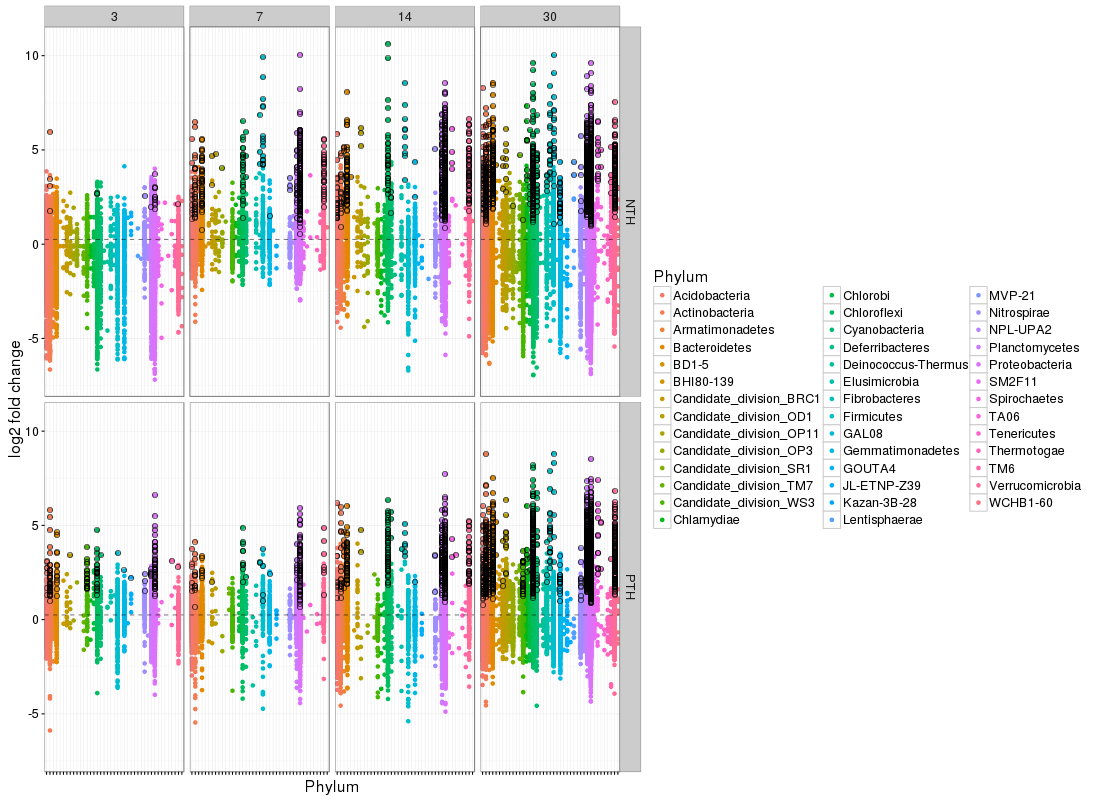

In [35]:
%%R -w 1100 -h 800

df.l2fc.f.f = df.l2fc.f %>%
    filter(Treatment == '13C') %>%
    mutate(Rank2 = Rank2 %>% as.character)


df.l2fc.f.f = df.l2fc.f.f %>%
    mutate(Rank2 = gsub('^__', '', Rank2))

df.l2fc.f.f.sig = df.l2fc.f.f %>%
    filter(padj < padj_cutoff) %>%
    mutate(Rank2 = gsub('^__', '', Rank2))

p.l2fc.x = ggplot(df.l2fc.f.f, aes(Rank2, color=Rank2)) +
    geom_point(aes(y=log2FoldChange)) +
    geom_point(data=df.l2fc.f.f.sig, aes(y=log2FoldChange), shape='O', color='black', alpha=0.8, size=2.5) +
    geom_hline(yintercept=l2fc_threshold, alpha=0.5, linetype='dashed') +
    facet_grid(Land_Management ~ Day ) +
    scale_color_discrete('Phylum') +
    labs(x = 'Phylum', y='log2 fold change') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_blank() 
        )
p.l2fc.x

In [36]:
%%R -i figDir
outFile = 'l2fc_sparCutMax_byPhylumX.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
ggsave(outFile, p.l2fc.x, width=12, height=4)

outFile = 'l2fc_sparCutMax_byPhylumX2.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
ggsave(outFile, p.l2fc.x, width=12, height=8)

## l2fc plot of the richest phyla in the dataset

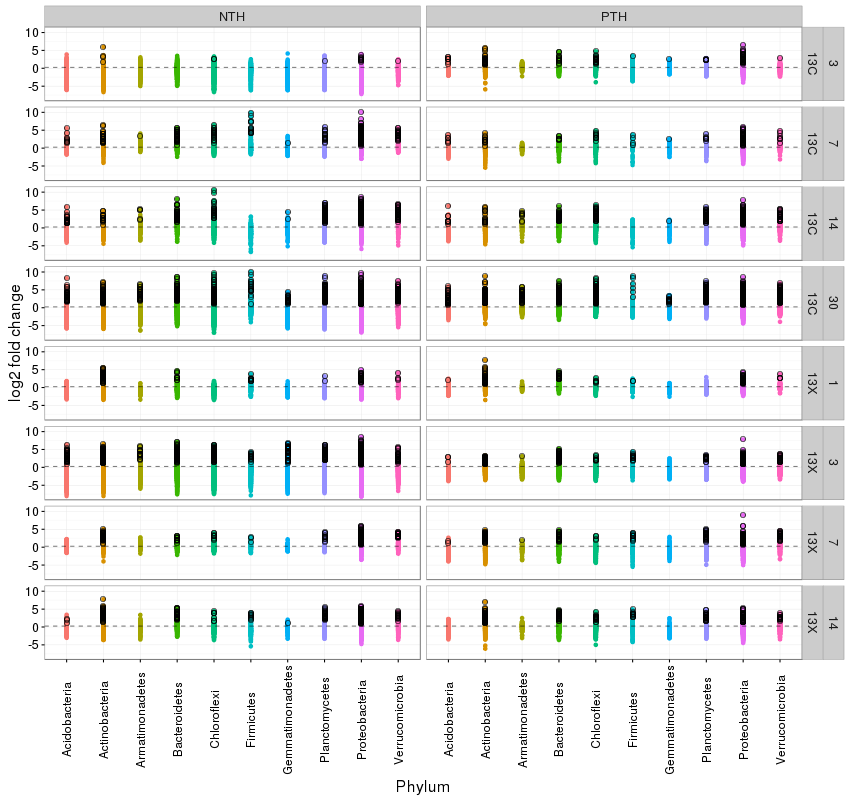

In [37]:
%%R -w 850 -h 800

df.l2fc.f.f = df.l2fc.f %>%
    mutate(Rank2 = gsub('^__', '', Rank2)) %>%
    group_by(Rank2) %>%
    mutate(n_OTU = OTU %>% unique %>% length) %>%
    ungroup() %>%
    mutate(n_OTU_rank = dense_rank(-n_OTU)) %>%
    filter(n_OTU_rank <= 10) 

df.l2fc.f.f.sig = df.l2fc.f.f %>%
    filter(padj < padj_cutoff) %>%
    mutate(Rank2 = gsub('^__', '', Rank2))

p.l2fc = ggplot(df.l2fc.f.f, aes(Rank2, color=Rank2)) +
    geom_point(aes(y=log2FoldChange)) +
    geom_point(data=df.l2fc.f.f.sig, aes(y=log2FoldChange), shape='O', color='black', alpha=0.8, size=2.5) +
    geom_hline(yintercept=l2fc_threshold, alpha=0.5, linetype='dashed') +
    facet_grid(Treatment ~ Day ~ Land_Management) +
    scale_color_discrete('Phylum') +
    labs(x = 'Phylum', y='log2 fold change') +
    theme_bw() +
    theme(
        text = element_text(size=16),
         axis.text.x  = element_text(angle=90, vjust=0.5, size=12)
        )  + guides(color = FALSE)

df.l2fc.f.f = NULL
df.l2fc.f.f.sig = NULL

p.l2fc

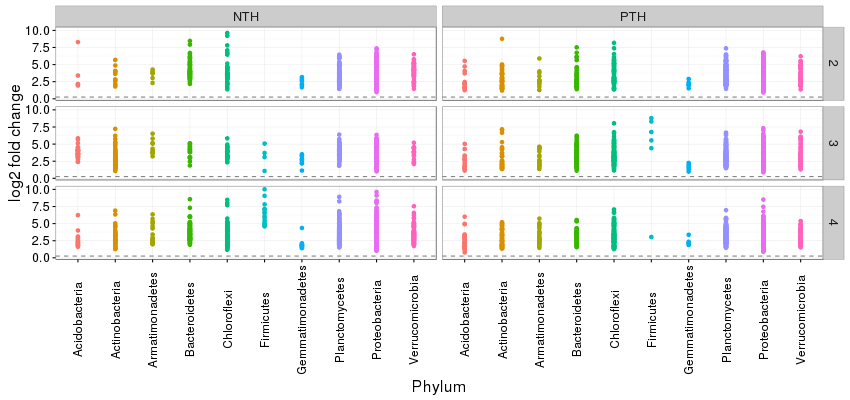

In [38]:
%%R -w 850 -h 400

df.l2fc.f.f = df.l2fc.f %>%
    mutate(Rank2 = gsub('^__', '', Rank2)) %>%
    group_by(Rank2) %>%
    mutate(n_OTU = OTU %>% unique %>% length) %>%
    ungroup() %>%
    mutate(n_OTU_rank = dense_rank(-n_OTU)) %>%
    filter(n_OTU_rank <= 10, Treatment == '13C', Day == '30', padj <=0.10) 

df.l2fc.f.f.sig = df.l2fc.f.f %>%
    filter(padj < padj_cutoff) %>%
    mutate(Rank2 = gsub('^__', '', Rank2))

p.l2fc = ggplot(df.l2fc.f.f, aes(Rank2, color=Rank2)) +
    geom_point(aes(y=log2FoldChange)) +
    #geom_point(data=df.l2fc.f.f.sig, aes(y=log2FoldChange), shape='O', color='black', alpha=0.8, size=2.5) +
    geom_hline(yintercept=l2fc_threshold, alpha=0.5, linetype='dashed') +
    facet_grid(Replicate ~ Land_Management) +
    scale_color_discrete('Phylum') +
    labs(x = 'Phylum', y='log2 fold change') +
    theme_bw() +
    theme(
        text = element_text(size=16),
       axis.text.x  = element_text(angle=90, vjust=0.5, size=12)
        )  + guides(color = FALSE)

df.l2fc.f.f = NULL
df.l2fc.f.f.sig = NULL

p.l2fc

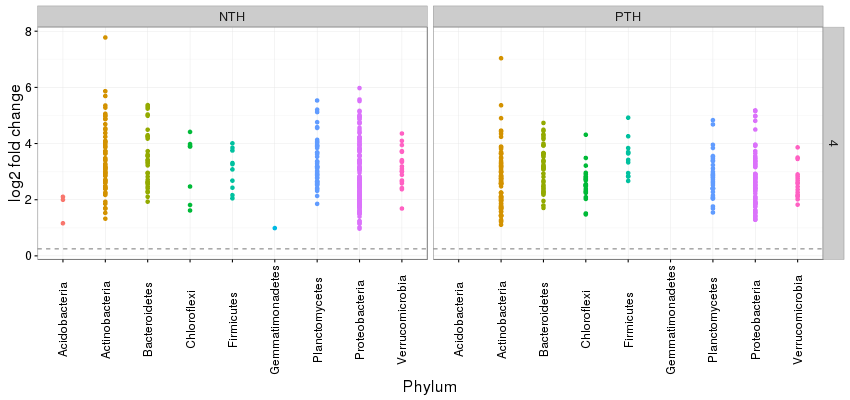

In [39]:
%%R -w 850 -h 400

df.l2fc.f.f = df.l2fc.f %>%
    mutate(Rank2 = gsub('^__', '', Rank2)) %>%
    group_by(Rank2) %>%
    mutate(n_OTU = OTU %>% unique %>% length) %>%
    ungroup() %>%
    mutate(n_OTU_rank = dense_rank(-n_OTU)) %>%
    filter(n_OTU_rank <= 10, Treatment == '13X', Day == '14', padj <=0.10) 

df.l2fc.f.f.sig = df.l2fc.f.f %>%
    filter(padj < padj_cutoff) %>%
    mutate(Rank2 = gsub('^__', '', Rank2))

p.l2fc = ggplot(df.l2fc.f.f, aes(Rank2, color=Rank2)) +
    geom_point(aes(y=log2FoldChange)) +
    #geom_point(data=df.l2fc.f.f.sig, aes(y=log2FoldChange), shape='O', color='black', alpha=0.8, size=2.5) +
    geom_hline(yintercept=l2fc_threshold, alpha=0.5, linetype='dashed') +
    facet_grid(Replicate ~ Land_Management) +
    scale_color_discrete('Phylum') +
    labs(x = 'Phylum', y='log2 fold change') +
    theme_bw() +
    theme(
        text = element_text(size=16),
       axis.text.x  = element_text(angle=90, vjust=0.5, size=12)
        )  + guides(color = FALSE)

df.l2fc.f.f = NULL
df.l2fc.f.f.sig = NULL

p.l2fc

In [40]:
%%R -i figDir
outFile = 'l2fc_sparCutMax_byPhylum-rich10.pdf'
outFile = file.path(figDir, outFile)
ggsave(outFile, p.l2fc, width=11, height=9)

### Number of incorporators per treatment

In [41]:
%%R
head(df.l2fc.f.Sig)


Error in head(df.l2fc.f.Sig) : object 'df.l2fc.f.Sig' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in head(df.l2fc.f.Sig) : object 'df.l2fc.f.Sig' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: In addition: 
  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: There were 15 warnings (use warnings() to see them)
  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 

  res = super(Function, self).__call__(*new_args, **new_kwargs)


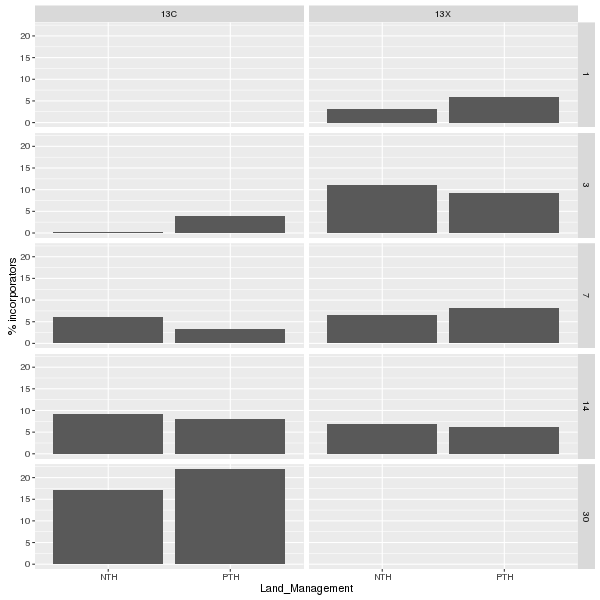

In [42]:
%%R -h 600 -w 600


df.l2fc.f.Sig = df.l2fc.f %>%
    group_by(Treatment, Day,Land_Management) %>%
    summarize(n_taxa = length(unique(OTU)),
              n_incorp = sum(padj < padj_cutoff),
              n_incorp_perc = n_incorp / n_taxa * 100)
              

df.l2fc.f.Sig$Treatment = reorder(df.l2fc.f.Sig$Treatment, -df.l2fc.f.Sig$n_incorp_perc)

p.nIncSub = ggplot(df.l2fc.f.Sig, aes(Land_Management, n_incorp_perc)) +
    geom_bar(stat='identity') + 
    labs(y='% incorporators') + facet_grid(Day~Treatment)
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1),
        axis.title.x = element_blank()
        )
p.nIncSub

#### Notes

* The figure shows the number of incorporators normalized by the number of taxa in observed in any gradient fraction associated with that substrate.

### Number of incorporators per treatment/time

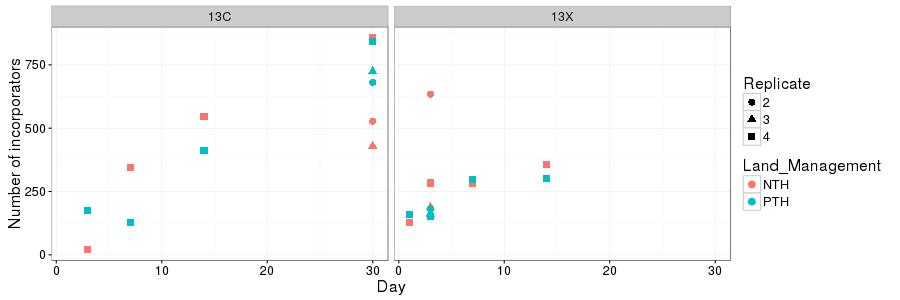

In [43]:
%%R -w 900 -h 300

df.l2fc.f.sig = df.l2fc.f %>%
    mutate(Day = Day %>% as.character %>% as.numeric) %>%
    group_by(Treatment, Day, Land_Management, Replicate) %>%
    summarize(n = sum(padj < padj_cutoff)) %>%
    ungroup()

p.nInc = ggplot(df.l2fc.f.sig, aes(Day, n, color=Land_Management, group=Land_Management, shape = Replicate)) +
    geom_point(size=3) +
    #geom_line(size=1.5, alpha=0.5) +
    labs(y='Number of incorporators') +
    theme_bw() +
    theme(
        text = element_text(size=16)
        ) + facet_wrap(~Treatment)
p.nInc

### Number of incorporators normalized by number of taxa in each sample

In [44]:
%%R
df.l2fc.f %>%
    group_by(Treatment, Day, Land_Management, Replicate) %>%
    summarize(ntaxa = n())

Source: local data frame [24 x 5]
Groups: Treatment, Day, Land_Management [?]

   Treatment    Day Land_Management Replicate ntaxa
       (chr) (fctr)           (chr)     (chr) (int)
1        13C      3             NTH         4  9350
2        13C      3             PTH         4  4524
3        13C      7             NTH         4  5758
4        13C      7             PTH         4  3810
5        13C     14             NTH         4  5923
6        13C     14             PTH         4  5122
7        13C     30             NTH         2  9917
8        13C     30             NTH         3  5978
9        13C     30             NTH         4 10309
10       13C     30             PTH         2  9358
..       ...    ...             ...       ...   ...


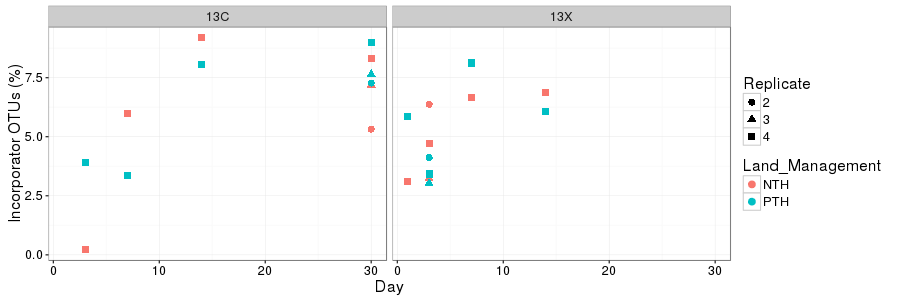

In [45]:
%%R -w 900 -h 300

df.l2fc.f.sig = df.l2fc.f %>%
    mutate(Day = Day %>% as.character %>% as.numeric) %>%
    group_by(Treatment, Day, Land_Management, Replicate) %>%
    mutate(ntaxa = n()) %>%
    group_by(Treatment, Day, Land_Management, Replicate, ntaxa) %>%
    summarize(n_incorp = sum(padj < padj_cutoff)) %>%
    mutate(n_incorp_norm_perc = n_incorp / ntaxa * 100) %>%
    ungroup()

p.nInc.norm = ggplot(df.l2fc.f.sig, aes(Day, n_incorp_norm_perc, color=Land_Management, group=Land_Management,
                                        shape = Replicate)) +
    geom_point(size=3) +
    #geom_line(size=1.5, alpha=0.5) +
    labs(y='Incorporator OTUs (%)') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.title.y = element_text(vjust=1)
        ) + facet_wrap(~Treatment)
p.nInc.norm

In [46]:
%%R -i figDir
outFile = 'l2fc_sparCutMax_nIncNorm.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
ggsave(outFile, p.nInc.norm, width=10, height=3.5)

In [47]:
%%R -i figDir
outFile = 'l2fc_sparCutMax_nIncNorm-labile.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
ggsave(outFile, p.nInc.norm.labile, width=10, height=3.5)


Error in grid.draw(plot) : object 'p.nInc.norm.labile' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in grid.draw(plot) : object 'p.nInc.norm.labile' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?

  res = super(Function, self).__call__(*new_args, **new_kwargs)


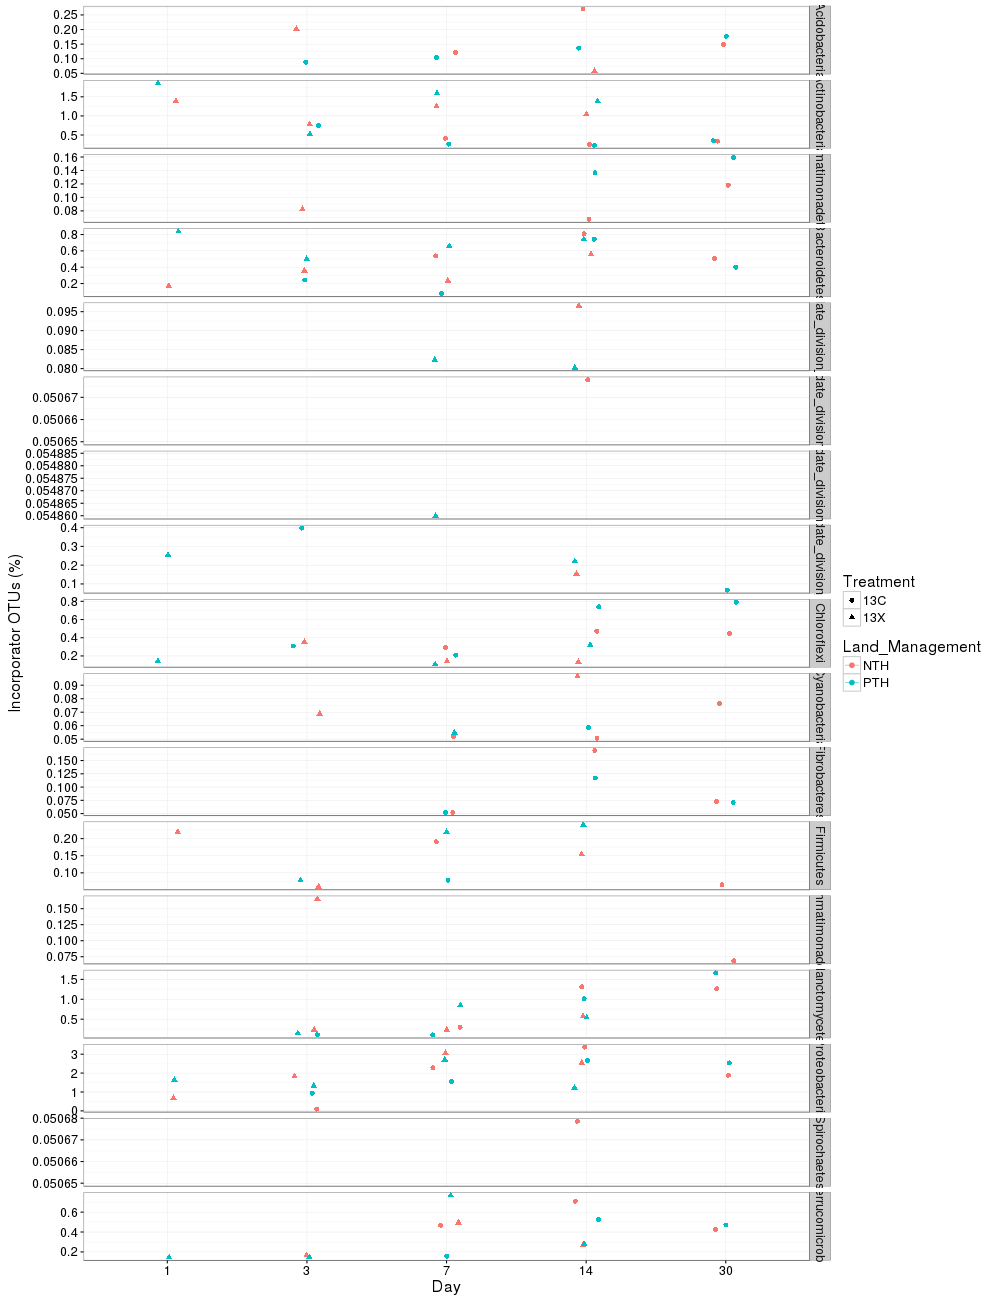

In [48]:
%%R -w 1000 -h 1300

padj_cutoff = 0.05
n_incorp_norm_perc_cutoff = 0.05

df.l2fc.f.sig = df.l2fc.f %>%
    group_by(Treatment, Day, Land_Management) %>%
    mutate(ntaxa = n()) %>%
    group_by(Treatment, Day, Land_Management, Rank2, ntaxa) %>%
    summarize(n_incorp = sum(padj < padj_cutoff)) %>%
    mutate(n_incorp_norm_perc = n_incorp / ntaxa * 100) %>%
    ungroup %>%
    mutate(Rank2 = gsub('^__', '', Rank2)) %>%
    filter(n_incorp_norm_perc >= n_incorp_norm_perc_cutoff)

ggplot(df.l2fc.f.sig, aes(Day, n_incorp_norm_perc, color=Land_Management, shape = Treatment)) +
    geom_jitter(size = 2, width = 0.25) +
    geom_line(alpha=0.5) +
    facet_grid(Rank2 ~ ., scales='free_y') +
    labs(y='Incorporator OTUs (%)') +
    theme_bw() +
    theme(
        text = element_text(size=16)
        )

In [49]:
%%R
df.l2fc.f.sig %>% arrange(Rank2) %>% as.data.frame

    Treatment Day Land_Management                   Rank2 ntaxa n_incorp
1         13C   3             PTH           Acidobacteria  4524        4
2         13C   7             NTH           Acidobacteria  5758        7
3         13C   7             PTH           Acidobacteria  3810        4
4         13C  14             NTH           Acidobacteria  5923       16
5         13C  14             PTH           Acidobacteria  5122        7
6         13C  30             NTH           Acidobacteria 26204       39
7         13C  30             PTH           Acidobacteria 28219       50
8         13X   3             NTH           Acidobacteria 21760       44
9         13X  14             NTH           Acidobacteria  5178        3
10        13C   3             PTH          Actinobacteria  4524       34
11        13C   7             NTH          Actinobacteria  5758       24
12        13C   7             PTH          Actinobacteria  3810       10
13        13C  14             NTH          Actinoba

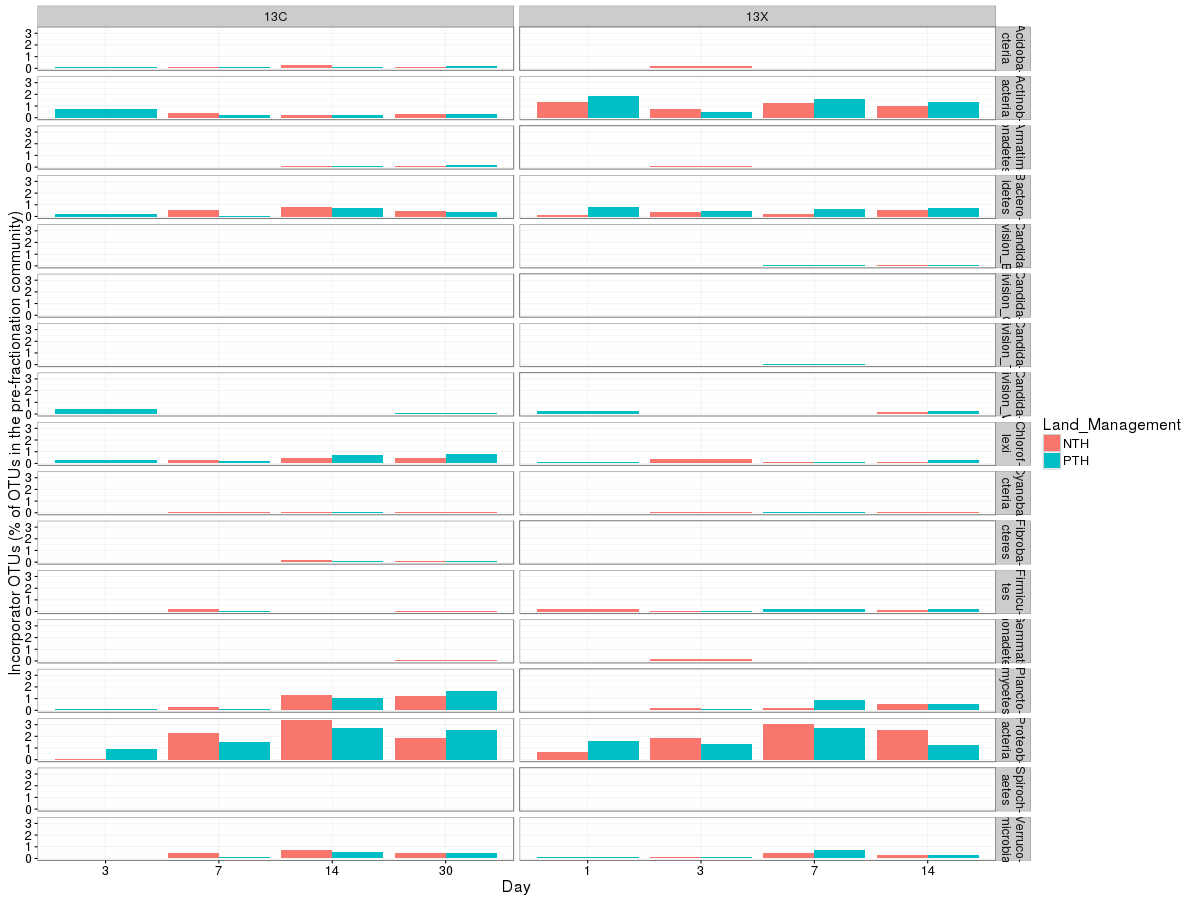

In [50]:
%%R -w 1200 -h 900

df.l2fc.f.sig.e = df.l2fc.f.sig %>%
    mutate(Day = Day %>% as.character,
           Rank2 = gsub('^(.{7})', '\\1-\n', Rank2))

df.l2fc.f.sig.e$Day = reorder(df.l2fc.f.sig.e$Day, df.l2fc.f.sig.e$Day %>% as.numeric)

ggplot(df.l2fc.f.sig.e, aes(Day, n_incorp_norm_perc, fill=Land_Management)) +
    geom_bar(stat='identity', position='dodge') +
    facet_grid(Rank2 ~ Treatment, scales='free_x', space='free') +
    labs(y='Incorporator OTUs (% of OTUs in the pre-fractionation community)') +
    theme_bw() +
    theme(
        text = element_text(size=16)
        ) 

## Plotting normalized by total taxa in phylulm

In [51]:
%%R
n_OTUs_phylum = df.l2fc.f %>% 
    group_by(Treatment, Land_Management, Day, Rank2) %>%
    summarize(n_OTUs = n())

n_OTUs_phylum

Source: local data frame [538 x 5]
Groups: Treatment, Land_Management, Day [?]

   Treatment Land_Management    Day                   Rank2 n_OTUs
       (chr)           (chr) (fctr)                   (chr)  (int)
1        13C             NTH      3           Acidobacteria    935
2        13C             NTH      3          Actinobacteria   1115
3        13C             NTH      3         Armatimonadetes    150
4        13C             NTH      3           Bacteroidetes    464
5        13C             NTH      3                   BD1-5      2
6        13C             NTH      3               BHI80-139      7
7        13C             NTH      3 Candidate_division_BRC1     31
8        13C             NTH      3  Candidate_division_OD1     46
9        13C             NTH      3 Candidate_division_OP11     15
10       13C             NTH      3  Candidate_division_OP3     33
..       ...             ...    ...                     ...    ...


In [52]:
%%R

df.l2fc.f.sig.j = inner_join(df.l2fc.f.sig, n_OTUs_phylum, c('Day' = 'Day',
                                                              'Treatment' = 'Treatment',
                                                              'Land_Management' = 'Land_Management',
                                                              'Rank2' = 'Rank2')) %>%
                    mutate(n_incorp_normByPhylum_perc = n_incorp / n_OTUs * 100)
                             
df.l2fc.f.sig.j %>% head(n=3) %>% as.data.frame 

  Treatment Day Land_Management          Rank2 ntaxa n_incorp
1       13C   3             NTH Proteobacteria  9350        9
2       13C   3             PTH  Acidobacteria  4524        4
3       13C   3             PTH Actinobacteria  4524       34
  n_incorp_norm_perc n_OTUs n_incorp_normByPhylum_perc
1         0.09625668   2740                  0.3284672
2         0.08841733    531                  0.7532957
3         0.75154730    627                  5.4226475


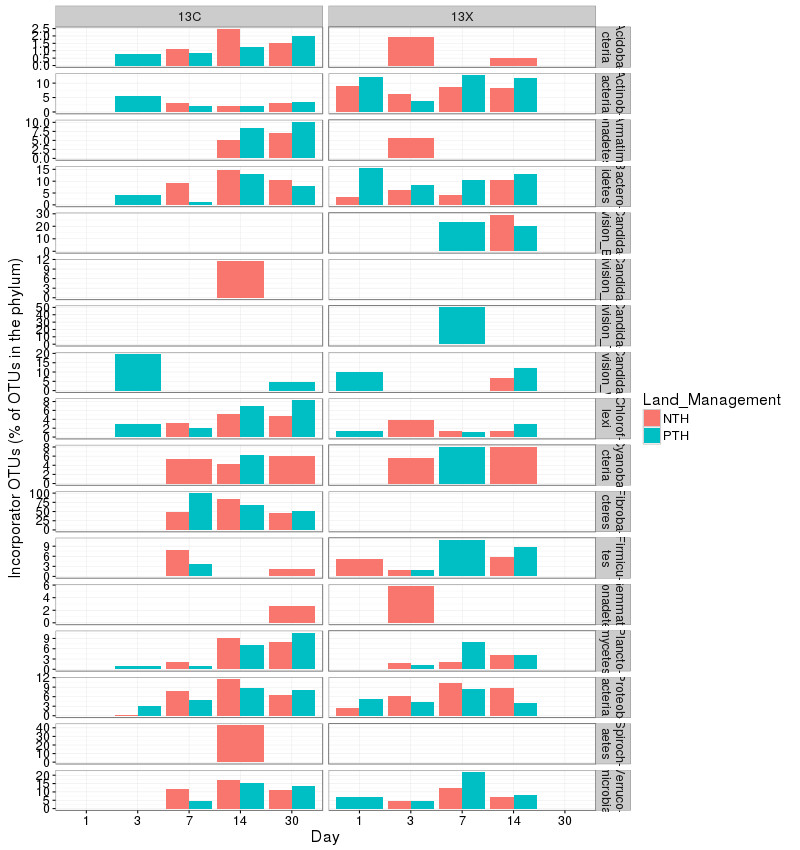

In [53]:
%%R -w 800 -h 850

df.l2fc.f.sig.j.e = df.l2fc.f.sig.j %>%
    mutate(Day = Day %>% as.character,
           Rank2 = gsub('^(.{7})', '\\1-\n', Rank2))

df.l2fc.f.sig.j.e$Day = reorder(df.l2fc.f.sig.j.e$Day, df.l2fc.f.sig.j.e$Day %>% as.numeric)

ggplot(df.l2fc.f.sig.j.e, aes(Day, n_incorp_normByPhylum_perc, fill=Land_Management)) +
    geom_bar(stat='identity', position='dodge') +
    facet_grid(Rank2 ~ Treatment, scales='free_y', space='fixed') +
    labs(y='Incorporator OTUs (% of OTUs in the phylum)') +
    theme_bw() +
    theme(
        text = element_text(size=16)
        )